In [1]:
import pandas as pd 
import numpy as np 
import rasterio 
from tqdm import tqdm
import os
from preprocessing import NDVIPreprocessing

In [2]:
{"type":"Polygon","coordinates":[[[106.254047,20.572905],[106.253237,20.571353],[106.251263,20.57173],[106.251778,20.573402],[106.254047,20.572905]]]}
{"type":"MultiPolygon","coordinates":[[[[106.254047,20.572905],[106.253237,20.571353],[106.251263,20.57173],[106.251778,20.573402],[106.254047,20.572905]]],[[[104.276792,21.79597],[104.276143,21.795282],[104.278085,21.794595],[104.278842,21.795741],[104.276792,21.79597]]]]}

{'type': 'MultiPolygon',
 'coordinates': [[[[106.254047, 20.572905],
    [106.253237, 20.571353],
    [106.251263, 20.57173],
    [106.251778, 20.573402],
    [106.254047, 20.572905]]],
  [[[104.276792, 21.79597],
    [104.276143, 21.795282],
    [104.278085, 21.794595],
    [104.278842, 21.795741],
    [104.276792, 21.79597]]]]}

In [3]:
'''LIST_FOLDER =  ['dakya_gialai','haiduong','hue','hungson_processing','huy_longan',
                'kienxuong_thaibinh','kimson_ninhbinh','longmy_haugiang','namdinh']'''

LIST_FOLDER = [filename[:-5] for filename in os.listdir("E:/EK_Intern/CropMonitoring/api/cfg/json/data_new")]
#LIST_FOLDER = ['bn_tb', 'dakya', 'donghungThaiBinh', 'dong_son_th', 'giao_thuy_nam_dinh', 'haiduong', 'hai_hau_nam_dinh', 'ha_trung_th', 'hoa_lu_ninh_binh', 'hue']
ROOT_PATH = 'E:/EK_Intern/CropMonitoring/api/assets/img'
print(LIST_FOLDER)
print(len(['bn_tb', 'dakya', 'donghungThaiBinh', 'dong_son_th', 'giao_thuy_nam_dinh', 'haiduong', 'hai_hau_nam_dinh', 'ha_trung_th', 'hoa_lu_ninh_binh', 'hue']))

['bn_tb', 'dakya', 'donghungThaiBinh', 'dong_son_th', 'giao_thuy_nam_dinh', 'gia_vien_ninh_binh', 'haiduong', 'hai_hau_nam_dinh', 'ha_trung_th', 'hoang_hoa_th', 'hoa_lu_ninh_binh', 'hue', 'hunghaThaiBinh', 'hungson', 'huylongan', 'kim_son_ninh_binh', 'lucyenYenBai', 'my_loc_nam_dinh', 'namdinh', 'nam_truc_nam_dinh', 'nghialoYenBai', 'nho_quan_ninh_binh', 'ninhbinh', 'nong_cong_th', 'quang_xuong', 'quan_hoa_th', 'quynhphuThaiBinh', 'ruonglongmy', 'thaithuyThaiBinh', 'thieu_hoa_th', 'tho_xuan_th', 'tienhaiThaibinh', 'tranyenYenBai', 'trieu_son_th', 'truc_ninh_nam_dinh', 'vanchanYenBai', 'vinh_loc_th', 'vu_ban_nam_dinh', 'xuan_truong_nam_dinh', 'yen_dinh_th', 'yen_khanh_ninh_binh', 'yen_mo_ninh_binh', 'y_yen_nam_dinh']
10


# Sentinel 2 NDVI 

In [9]:
# Kiểm tra dữ liệu ngoại lai 
def check_outliers(list_ndvi):
    alpha = beta = 0.15
    gamma = -0.05
    for t in range(1, len(list_ndvi)-1):
        if list_ndvi[t-1] is None:
            continue
        if list_ndvi[t-1] is not None and list_ndvi[t] is not None and list_ndvi[t+1] is not None:
            c_alpha = np.abs(list_ndvi[t] - list_ndvi[t-1])
            c_beta = np.abs(list_ndvi[t+1] - list_ndvi[t])
            c_gamma = np.abs(list_ndvi[t+1] - list_ndvi[t-1])
            print(f"a = {c_alpha},  b = {c_beta}, g = {c_gamma}")
            if c_alpha >= alpha and c_beta >= beta and c_gamma >= gamma:
                list_ndvi[t] = None
    return list_ndvi

test_list = [0.6, 0.55, 0.1, 0.48, 0.4, 0]
test_list = check_outliers(test_list)
print(test_list)


a = 0.04999999999999993,  b = 0.45000000000000007, g = 0.5
a = 0.45000000000000007,  b = 0.38, g = 0.07000000000000006
a = 0.07999999999999996,  b = 0.4, g = 0.48
[0.6, 0.55, None, 0.48, 0.4, 0]


In [10]:
def count_pixel_cloud(data):
    min = 100
    index = None
    for i in range(0, len(data)):
        num_nan = np.isnan(data[i]).sum()
        total_pixel = data[i].shape[0] * data[i].shape[1]
        ratio_cloud = float(num_nan/total_pixel)
        if ratio_cloud < min:
            min = ratio_cloud
            index = i
    return min, index

In [11]:
arr_full = []
range_time = 4
print('Start process')

for name in LIST_FOLDER:
    arr = np.load(f'E:/EK_Intern/CropMonitoring/api/assets/np/{name}.npy')
    # Truy cập vào từng ảnh trong 1 vùng
    print(f'Khu vực {name}')
    area_ndvi_album = []
    for img_index in tqdm(range(0, arr.shape[0], range_time), desc='Processing: '):        
        # Lấy 4 ảnh 1 lần (theo tháng)
        series_img = arr[img_index:img_index + range_time, :, :]
        
        # Tìm ảnh có ít pixel mây nhất và lấy làm ảnh gốc
        min_cloud_pixels, index = count_pixel_cloud(series_img)
        image_fill = series_img[index, :, :]
        # Bù các pixel thiếu bằng cách lấy giá trị từ các ảnh khác trong chuỗi
        for x in range(arr.shape[1]):
            for y in range(arr.shape[2]):
                if np.isnan(image_fill[x, y]):  
                    for i in range(series_img.shape[0]):  
                        if i != index and not np.isnan(series_img[i, x, y]):
                            image_fill[x, y] = series_img[i, x, y]
                            break  
    
        area_ndvi_album.append(image_fill)

    arr_full.append(np.array(area_ndvi_album))
    
print('End process!!!')


Start process
Khu vực bn_tb


Processing: 100%|██████████| 53/53 [00:11<00:00,  4.43it/s]


Khu vực dakya


Processing: 100%|██████████| 53/53 [00:01<00:00, 32.96it/s]


Khu vực donghungThaiBinh


Processing: 100%|██████████| 53/53 [00:31<00:00,  1.69it/s]


Khu vực dong_son_th


Processing: 100%|██████████| 53/53 [02:03<00:00,  2.33s/it]


Khu vực giao_thuy_nam_dinh


Processing: 100%|██████████| 53/53 [01:08<00:00,  1.29s/it]


Khu vực haiduong


Processing: 100%|██████████| 53/53 [00:03<00:00, 17.19it/s]


Khu vực hai_hau_nam_dinh


Processing: 100%|██████████| 53/53 [03:24<00:00,  3.86s/it]


Khu vực ha_trung_th


Processing: 100%|██████████| 53/53 [00:05<00:00, 10.35it/s]


Khu vực hoa_lu_ninh_binh


Processing: 100%|██████████| 53/53 [00:42<00:00,  1.26it/s]


Khu vực hue


Processing: 100%|██████████| 53/53 [00:03<00:00, 14.36it/s]

End process!!!


In [12]:
process = NDVIPreprocessing()

In [14]:
def load_sentinel1():
    res = []
    for name in LIST_FOLDER: 
        path = f'{ROOT_PATH}/{name}/S1GRD'
        print(path)
        folder = []
        for image_path in tqdm(os.listdir(path), desc='Processing: '):
            img = process.make_S1_raster(f'{path}/{image_path}')
            folder.append(img)
        res.append(np.array(folder))
    return res

res = load_sentinel1()

E:/EK_Intern/CropMonitoring/api/assets/img/bn_tb/S1GRD


Processing: 100%|██████████| 209/209 [00:01<00:00, 111.03it/s]


E:/EK_Intern/CropMonitoring/api/assets/img/dakya/S1GRD


Processing: 100%|██████████| 209/209 [00:01<00:00, 147.37it/s]


E:/EK_Intern/CropMonitoring/api/assets/img/donghungThaiBinh/S1GRD


Processing: 100%|██████████| 209/209 [00:01<00:00, 108.52it/s]


E:/EK_Intern/CropMonitoring/api/assets/img/dong_son_th/S1GRD


Processing: 100%|██████████| 209/209 [00:03<00:00, 61.48it/s]


E:/EK_Intern/CropMonitoring/api/assets/img/giao_thuy_nam_dinh/S1GRD


Processing: 100%|██████████| 209/209 [00:02<00:00, 75.42it/s]


E:/EK_Intern/CropMonitoring/api/assets/img/haiduong/S1GRD


Processing: 100%|██████████| 209/209 [00:01<00:00, 143.93it/s]


E:/EK_Intern/CropMonitoring/api/assets/img/hai_hau_nam_dinh/S1GRD


Processing: 100%|██████████| 209/209 [00:04<00:00, 43.55it/s]


E:/EK_Intern/CropMonitoring/api/assets/img/ha_trung_th/S1GRD


Processing: 100%|██████████| 209/209 [00:01<00:00, 175.88it/s]


E:/EK_Intern/CropMonitoring/api/assets/img/hoa_lu_ninh_binh/S1GRD


Processing: 100%|██████████| 209/209 [00:01<00:00, 105.50it/s]


E:/EK_Intern/CropMonitoring/api/assets/img/hue/S1GRD


Processing: 100%|██████████| 209/209 [00:01<00:00, 178.41it/s]


In [15]:
arr_full[0][0].shape

(294, 262)

In [16]:
arr_full[0][0:4].shape

(4, 294, 262)

In [17]:
VH = []
VV = []
print('---------- Start Processing ----------')
for area_index in range(len(LIST_FOLDER)):
    list_VH_area_image = []
    list_VV_area_image = []
    print(f'Starting Loading Sentinel 1 GRD at {LIST_FOLDER[area_index]}')
    for image in tqdm(os.listdir(f'{ROOT_PATH}/{LIST_FOLDER[area_index]}/S1GRD'),desc='Processing: '):
        path_to_image=f'{ROOT_PATH}/{LIST_FOLDER[area_index]}/S1GRD/{image}'
        VV_band, VH_band = process.make_S1_raster(path_to_image)
        list_VH_area_image.append(VH_band)
        list_VV_area_image.append(VV_band)
    VH.append(np.array(list_VH_area_image))
    VV.append(np.array(list_VV_area_image))    

print('Done all')

---------- Start Processing ----------
Starting Loading Sentinel 1 GRD at bn_tb


Processing:   0%|          | 0/209 [00:00<?, ?it/s]

Processing: 100%|██████████| 209/209 [00:01<00:00, 155.78it/s]


Starting Loading Sentinel 1 GRD at dakya


Processing: 100%|██████████| 209/209 [00:01<00:00, 171.78it/s]


Starting Loading Sentinel 1 GRD at donghungThaiBinh


Processing: 100%|██████████| 209/209 [00:01<00:00, 130.28it/s]


Starting Loading Sentinel 1 GRD at dong_son_th


Processing: 100%|██████████| 209/209 [00:02<00:00, 75.61it/s]


Starting Loading Sentinel 1 GRD at giao_thuy_nam_dinh


Processing: 100%|██████████| 209/209 [00:02<00:00, 85.54it/s]


Starting Loading Sentinel 1 GRD at haiduong


Processing: 100%|██████████| 209/209 [00:01<00:00, 137.55it/s]


Starting Loading Sentinel 1 GRD at hai_hau_nam_dinh


Processing: 100%|██████████| 209/209 [00:04<00:00, 45.53it/s]


Starting Loading Sentinel 1 GRD at ha_trung_th


Processing: 100%|██████████| 209/209 [00:01<00:00, 138.42it/s]


Starting Loading Sentinel 1 GRD at hoa_lu_ninh_binh


Processing: 100%|██████████| 209/209 [00:02<00:00, 94.44it/s] 


Starting Loading Sentinel 1 GRD at hue


Processing: 100%|██████████| 209/209 [00:01<00:00, 157.07it/s]

Done all


In [18]:
VH[0][0:4,:,:].shape[2]

262

In [19]:
VH_full = []
VV_full = []
range_time = 4
print('Start process Sentinel 1 GRD:')

for area_index in range(len(LIST_FOLDER)):
    # Truy cập vào từng ảnh trong 1 vùng
    print(f'Khu vực {LIST_FOLDER[area_index]}')
    area_vh_album = []
    area_vv_album = []
    print(VH[area_index].shape)
    for img_index in tqdm(range(0,VH[area_index].shape[0],range_time),desc='Processing: '):        
        # Lấy 4 ảnh 1 lần (theo tháng)
        series_VH_img = VH[area_index][img_index:img_index + range_time,:,:]
        series_VV_img = VV[area_index][img_index:img_index + range_time,:,:]
        
        # Truy cập vào từng pixel
        image_VH_fill = np.full((series_VH_img.shape[1], series_VH_img.shape[2]), np.nan)
        image_VV_fill = np.full((series_VH_img.shape[1], series_VH_img.shape[2]), np.nan)
        
        for x in range(series_VH_img.shape[1]):
            for y in range(series_VH_img.shape[2]):
                vh_last_not_null = None
                vv_last_not_null = None
                for i in range(series_VH_img.shape[0]):
                    if np.isnan(series_VH_img[i,x,y]):
                        continue
                    elif np.isnan(series_VV_img[i,x,y]):
                        continue
                    else:
                        vh_last_not_null = series_VH_img[i,x,y]
                        vv_last_not_null = series_VV_img[i,x,y]
                image_VH_fill[x,y] = vh_last_not_null
                image_VV_fill[x,y] = vv_last_not_null
       
        area_vh_album.append(image_VH_fill)
        area_vv_album.append(image_VV_fill)
        
    VH_full.append(np.array(area_vh_album))
    VV_full.append(np.array(area_vv_album))

print('Done process!!!')

Start process Sentinel 1 GRD:
Khu vực bn_tb
(209, 294, 262)


Processing:   0%|          | 0/53 [00:00<?, ?it/s]

Processing: 100%|██████████| 53/53 [01:03<00:00,  1.20s/it]


Khu vực dakya
(209, 163, 108)


Processing: 100%|██████████| 53/53 [00:13<00:00,  3.97it/s]


Khu vực donghungThaiBinh
(209, 381, 629)


Processing: 100%|██████████| 53/53 [02:55<00:00,  3.31s/it]


Khu vực dong_son_th
(209, 1341, 714)


Processing:  53%|█████▎    | 28/53 [06:37<05:48, 13.93s/it]

In [21]:
IW_ratio = []  # VV/VH
IW_cross = []  # VH - VV

for area_index in range(len(LIST_FOLDER)):
    VH_area_album = VH_full[area_index]
    VV_area_album = VV_full[area_index]
    IW_ratio_area = []
    IW_cross_area = []
    for i in tqdm(range(len(VH_area_album)), desc='Calculating: '):
        imgVH = VH_area_album[i].astype(np.float64)  # Chuyển đổi sang float64
        imgVV = VV_area_album[i].astype(np.float64)  # Chuyển đổi sang float64
        # Sử dụng np.divide với điều kiện VH != 0
        img_IW_ratio = np.divide(imgVV, imgVH, out=np.zeros_like(imgVV, dtype=np.float64), where=imgVH != 0)
        img_IW_cross = imgVH - imgVV
        
        IW_ratio_area.append(img_IW_ratio)
        IW_cross_area.append(img_IW_cross)
        
    IW_ratio.append(np.array(IW_ratio_area))
    IW_cross.append(np.array(IW_cross_area))


Calculating: 100%|██████████| 53/53 [00:00<00:00, 1709.81it/s]


In [22]:
arr_ =[]
for index_ in range(len(LIST_FOLDER)):
    arr = arr_full[index_]
    arr_ratio = []
    for i in tqdm(range(arr.shape[0])):
        num_nan = np.isnan(arr[i]).sum()

        # Tính tổng số lượng phần tử trong mảng
        total_elements = arr.shape[1] * arr.shape[2]
        arr_ratio.append(float(num_nan/total_elements) * 100)
    arr_.append(arr_ratio)

100%|██████████| 53/53 [00:00<00:00, 5890.25it/s]


IndexError: list index out of range

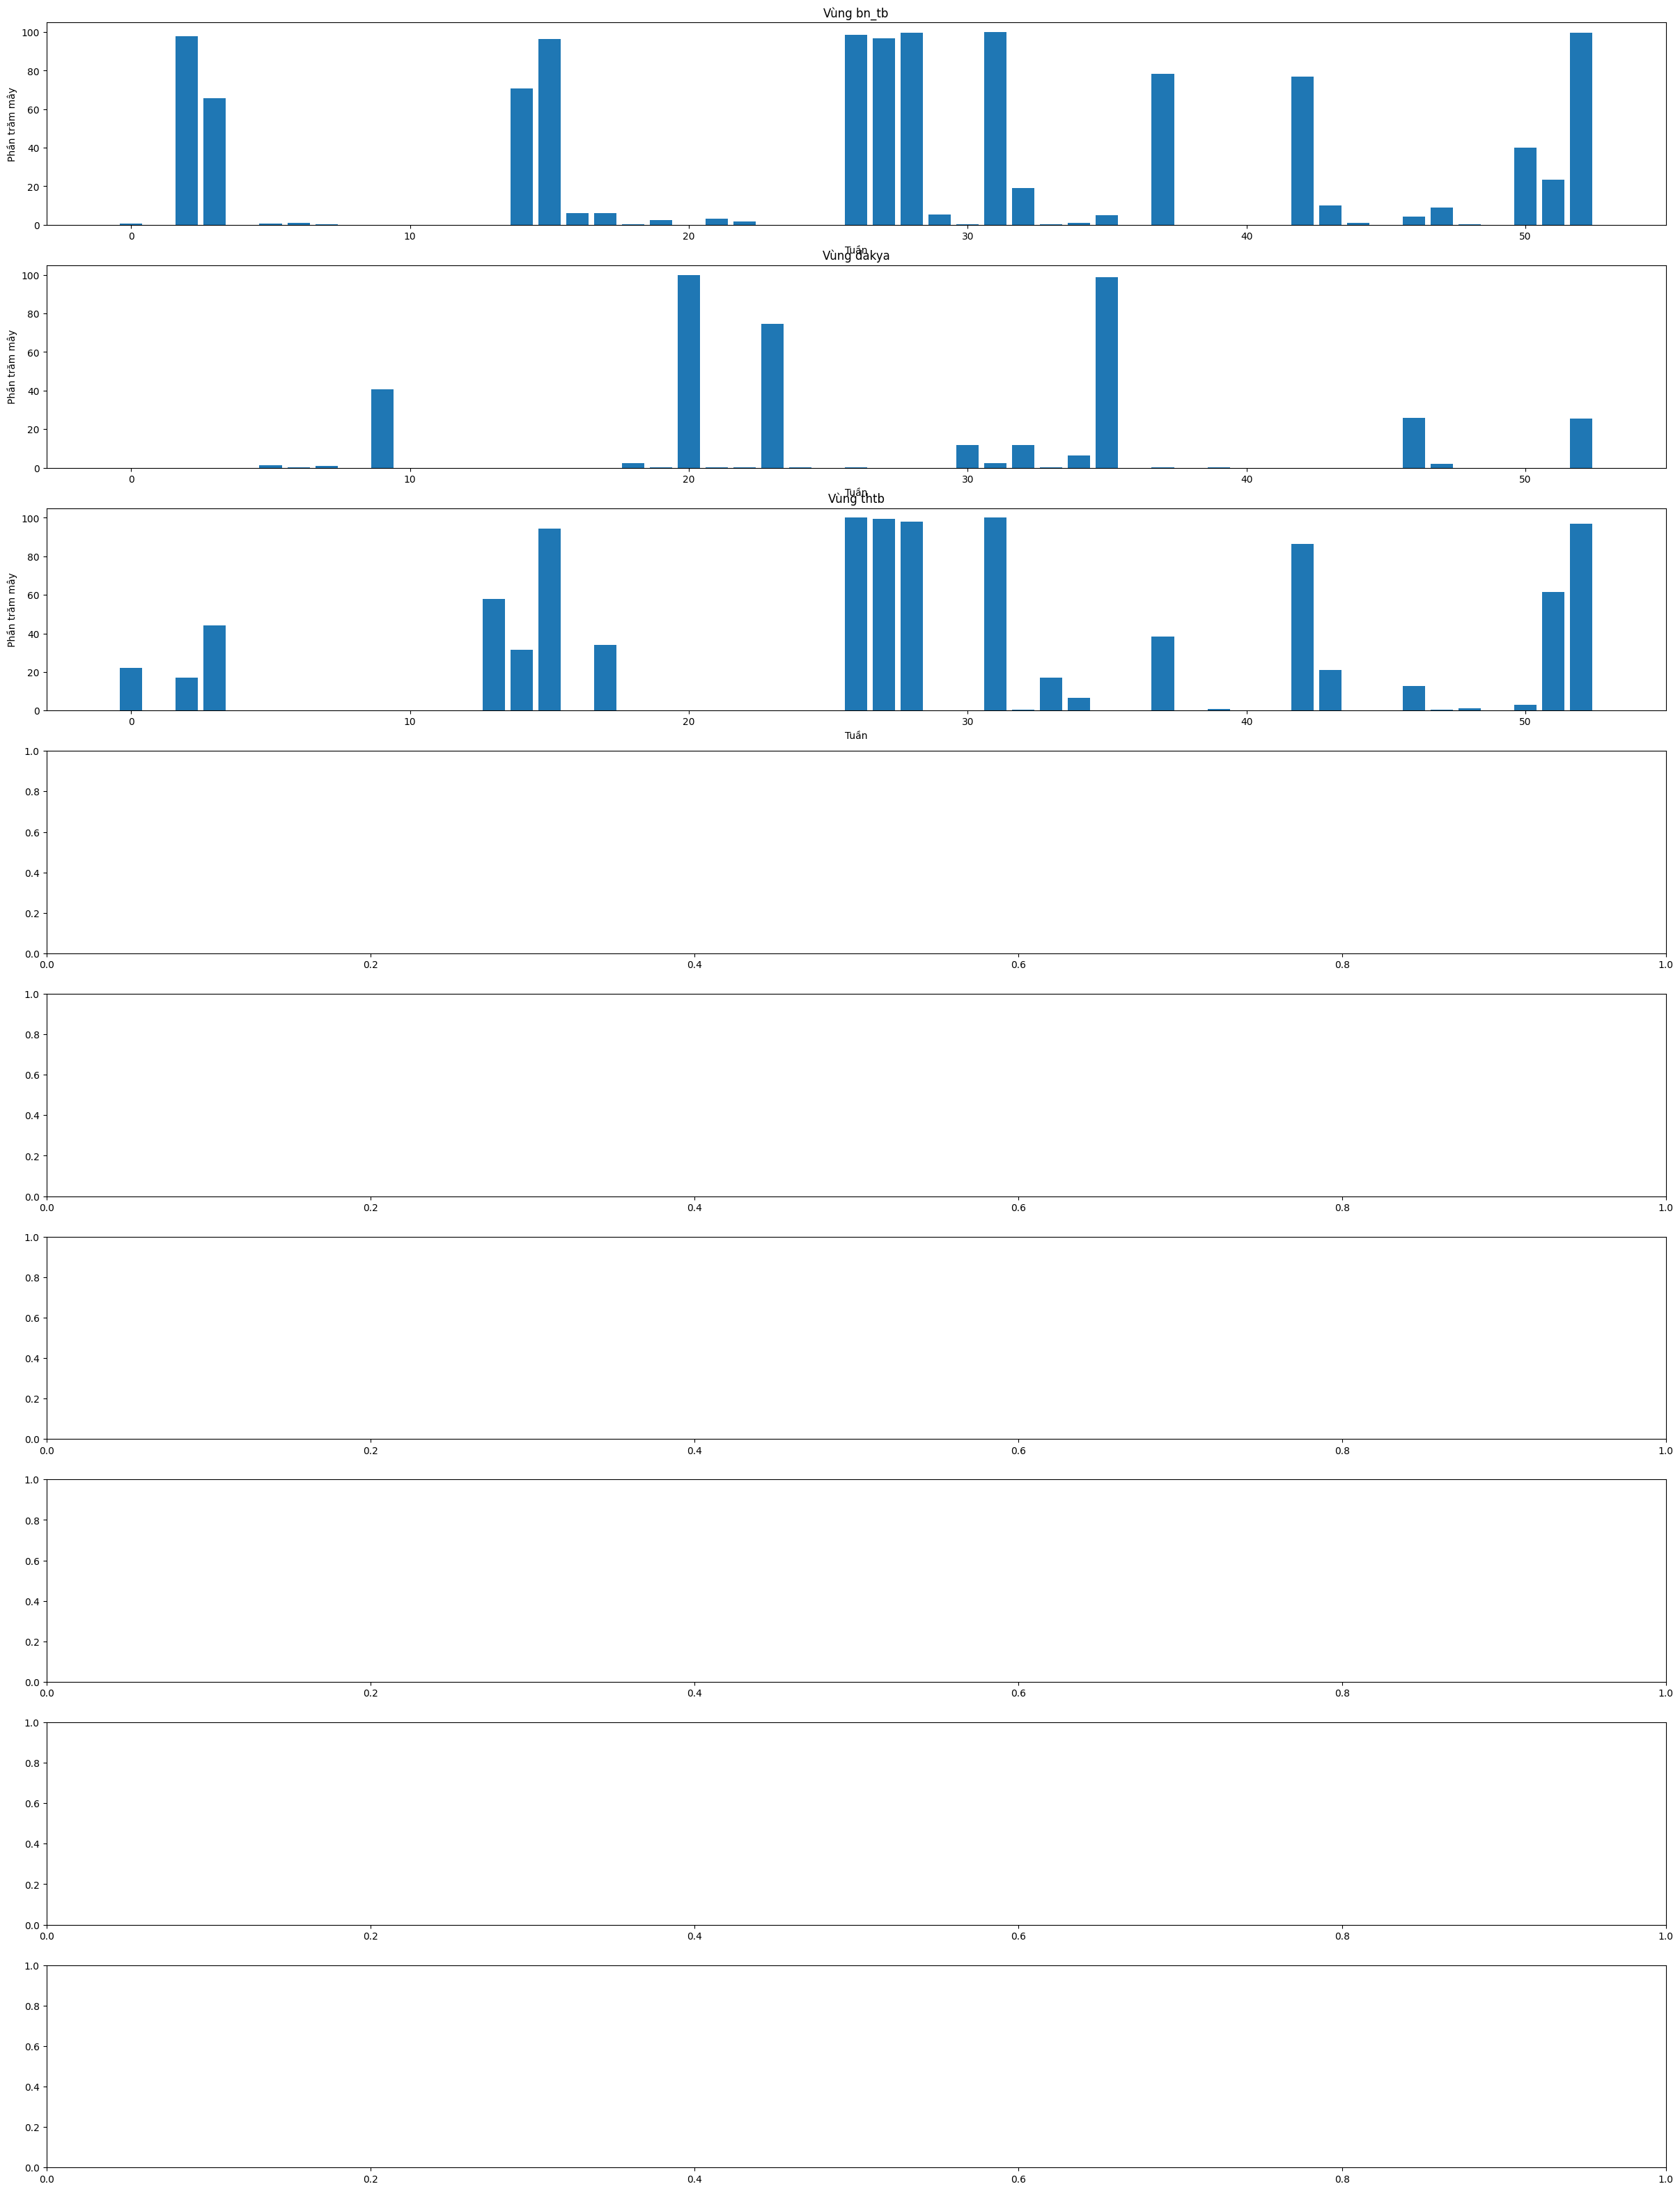

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu ví dụ cho 9 biểu đồ cột
data =  arr_ # 9 bộ dữ liệu, mỗi bộ có 5 giá trị

# Tạo figure và lưới các subplots 3x3
fig, axes = plt.subplots(9, 1, figsize=(30, 40))

# Duyệt qua các axes và vẽ biểu đồ cột
for i, ax in enumerate(axes.flat):
    ax.bar(range(len(data[i])), data[i])
    ax.set_title(f'Vùng {LIST_FOLDER[i]}')
    ax.set_xlabel('Tuần')
    ax.set_ylabel('Phần trăm mây')

# Tự động căn chỉnh layout để tránh bị trùng lặp nội dung
plt.tight_layout()
plt.show()

IndexError: list index out of range

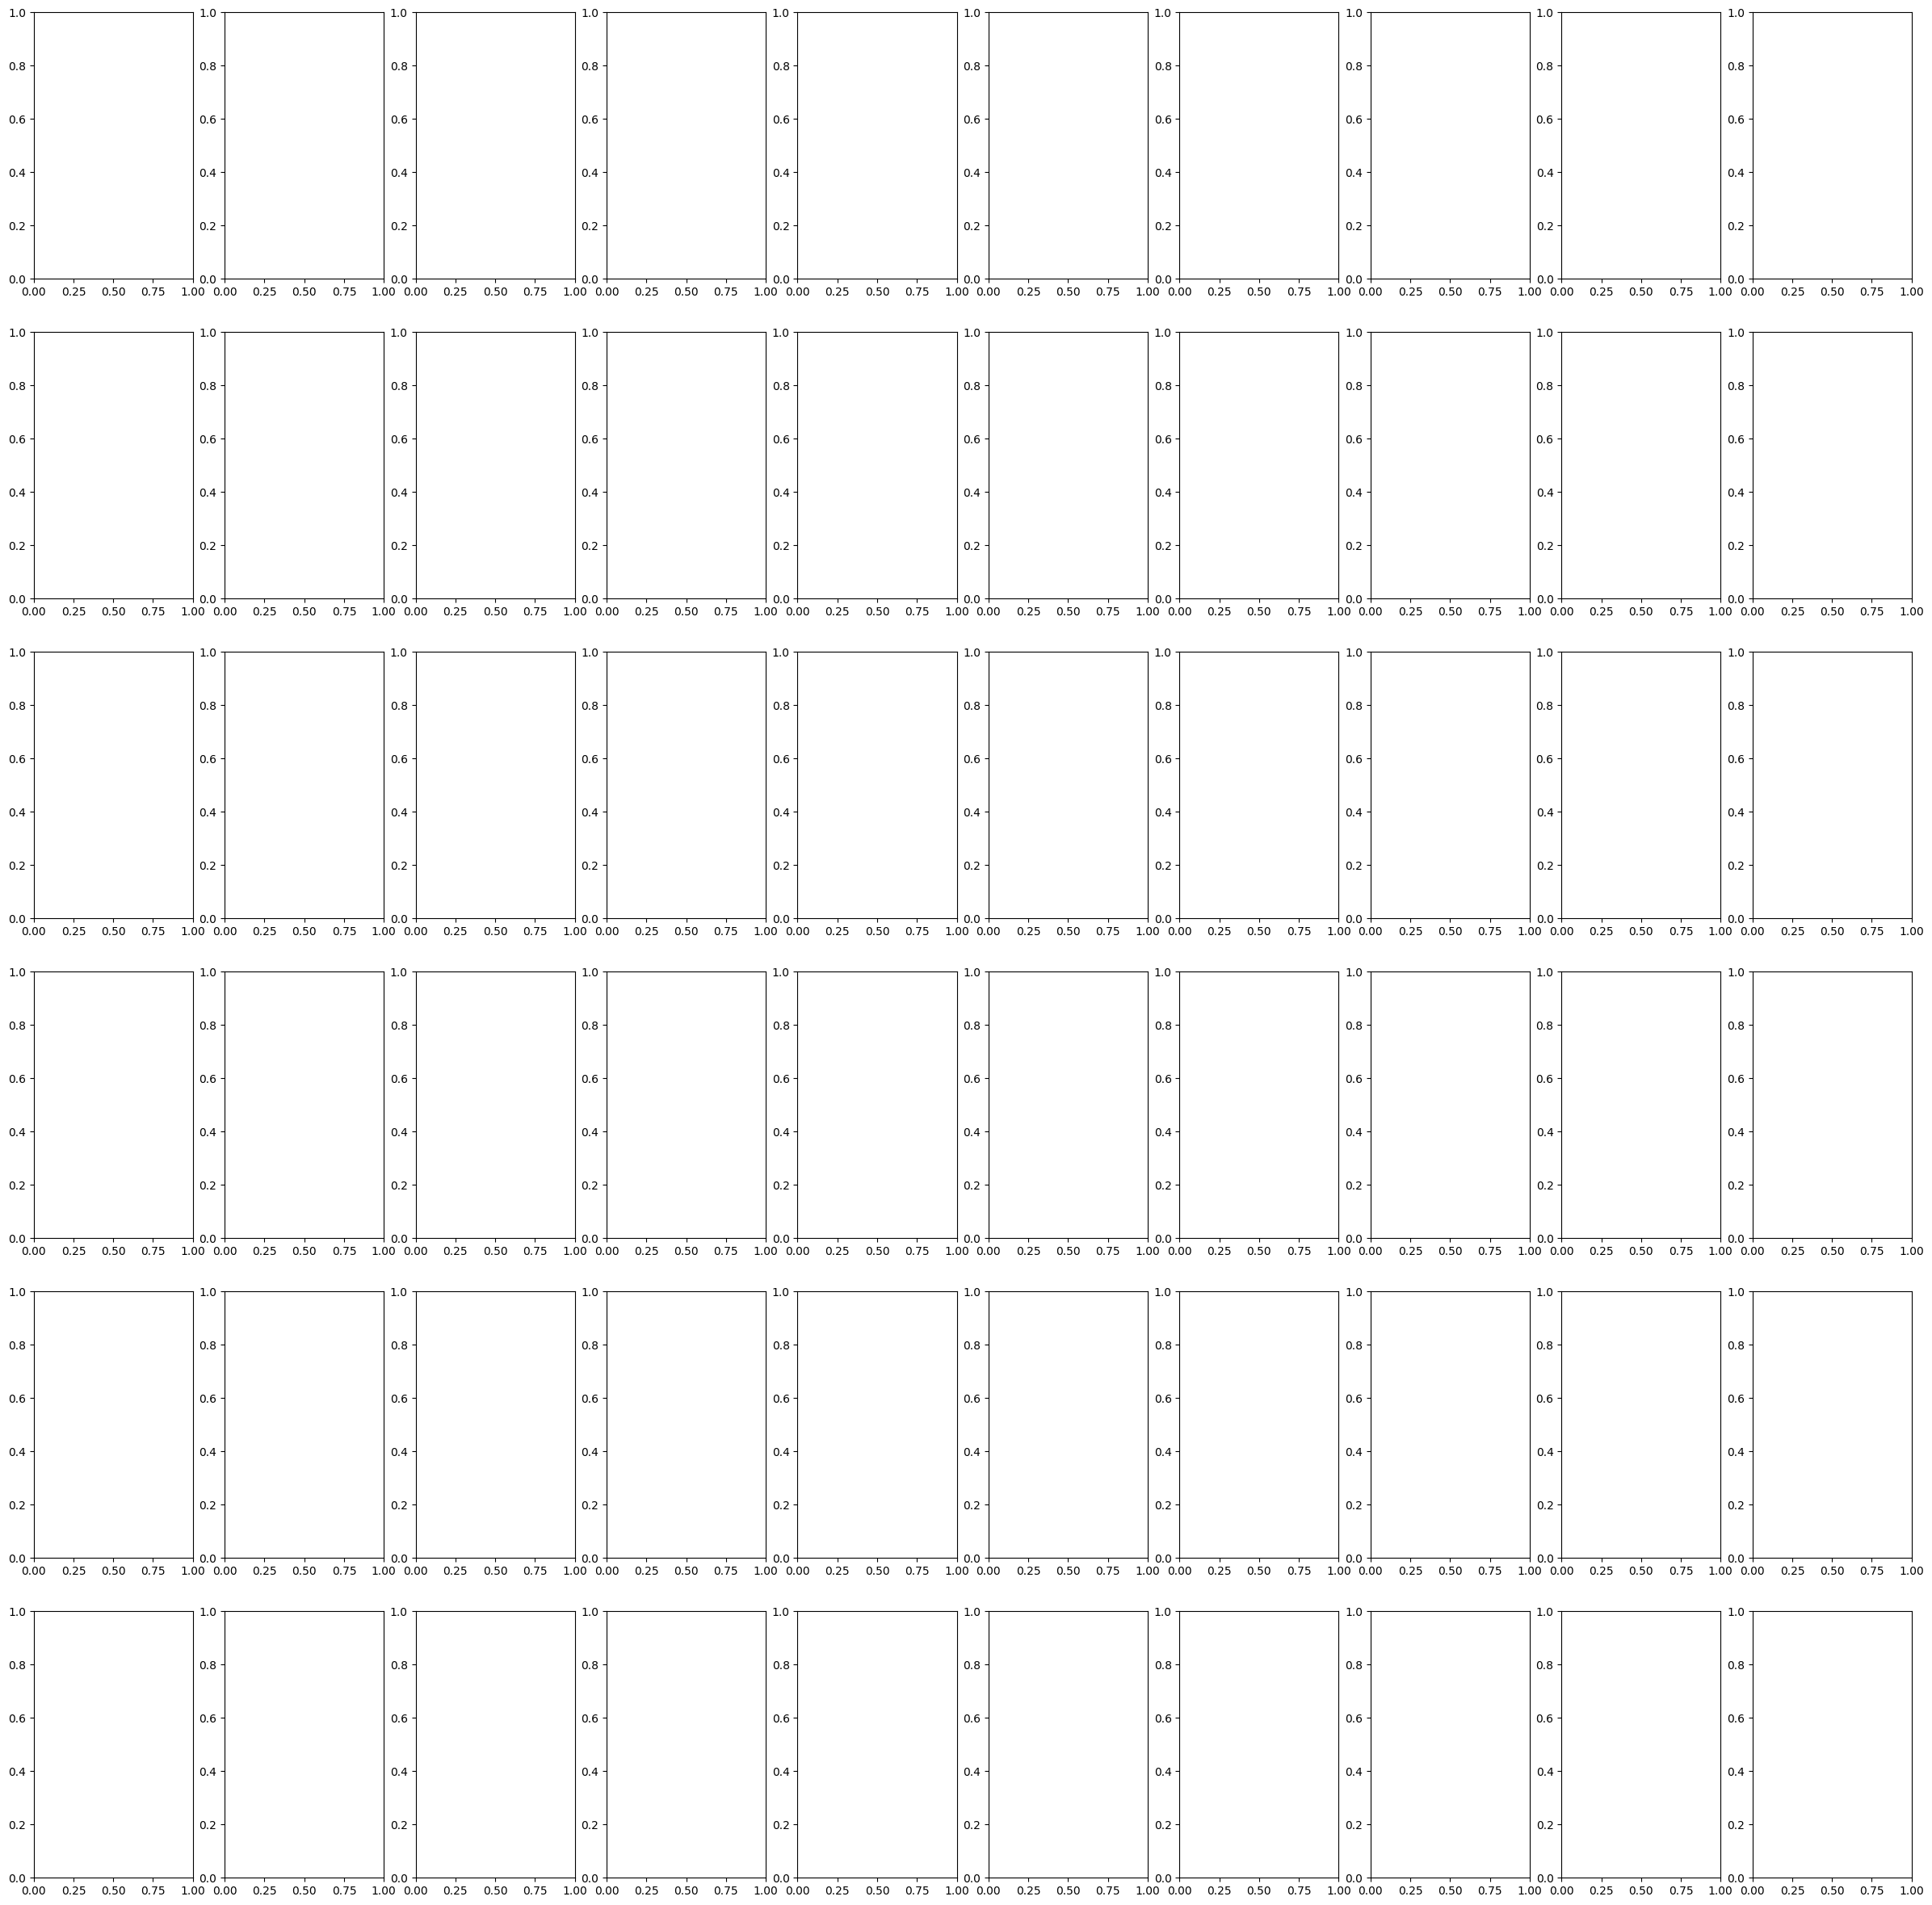

In [24]:
# Vẽ mảng 2D dưới dạng hình ảnh
import matplotlib.pyplot as plt 

# Tạo bảng 2x5 để hiển thị 10 ảnh
fig, axs = plt.subplots(6, 10, figsize=(30, 30))

# Vẽ từng ảnh trong bảng
for i, ax in enumerate(axs.flat):
    ax.imshow(arr_full[8][i,:,:], cmap='viridis', vmax=1, vmin=-1)  
    ax.set_title(f'Month {i+1}')
    ax.axis('off')  # Ẩn các trục

# Thêm khoảng cách giữa các ô
plt.tight_layout()
plt.show()

In [ ]:
dakya = np.load('D:/Streamlit/api/assets/np/namdinh.npy')

IndexError: index 209 is out of bounds for axis 0 with size 209

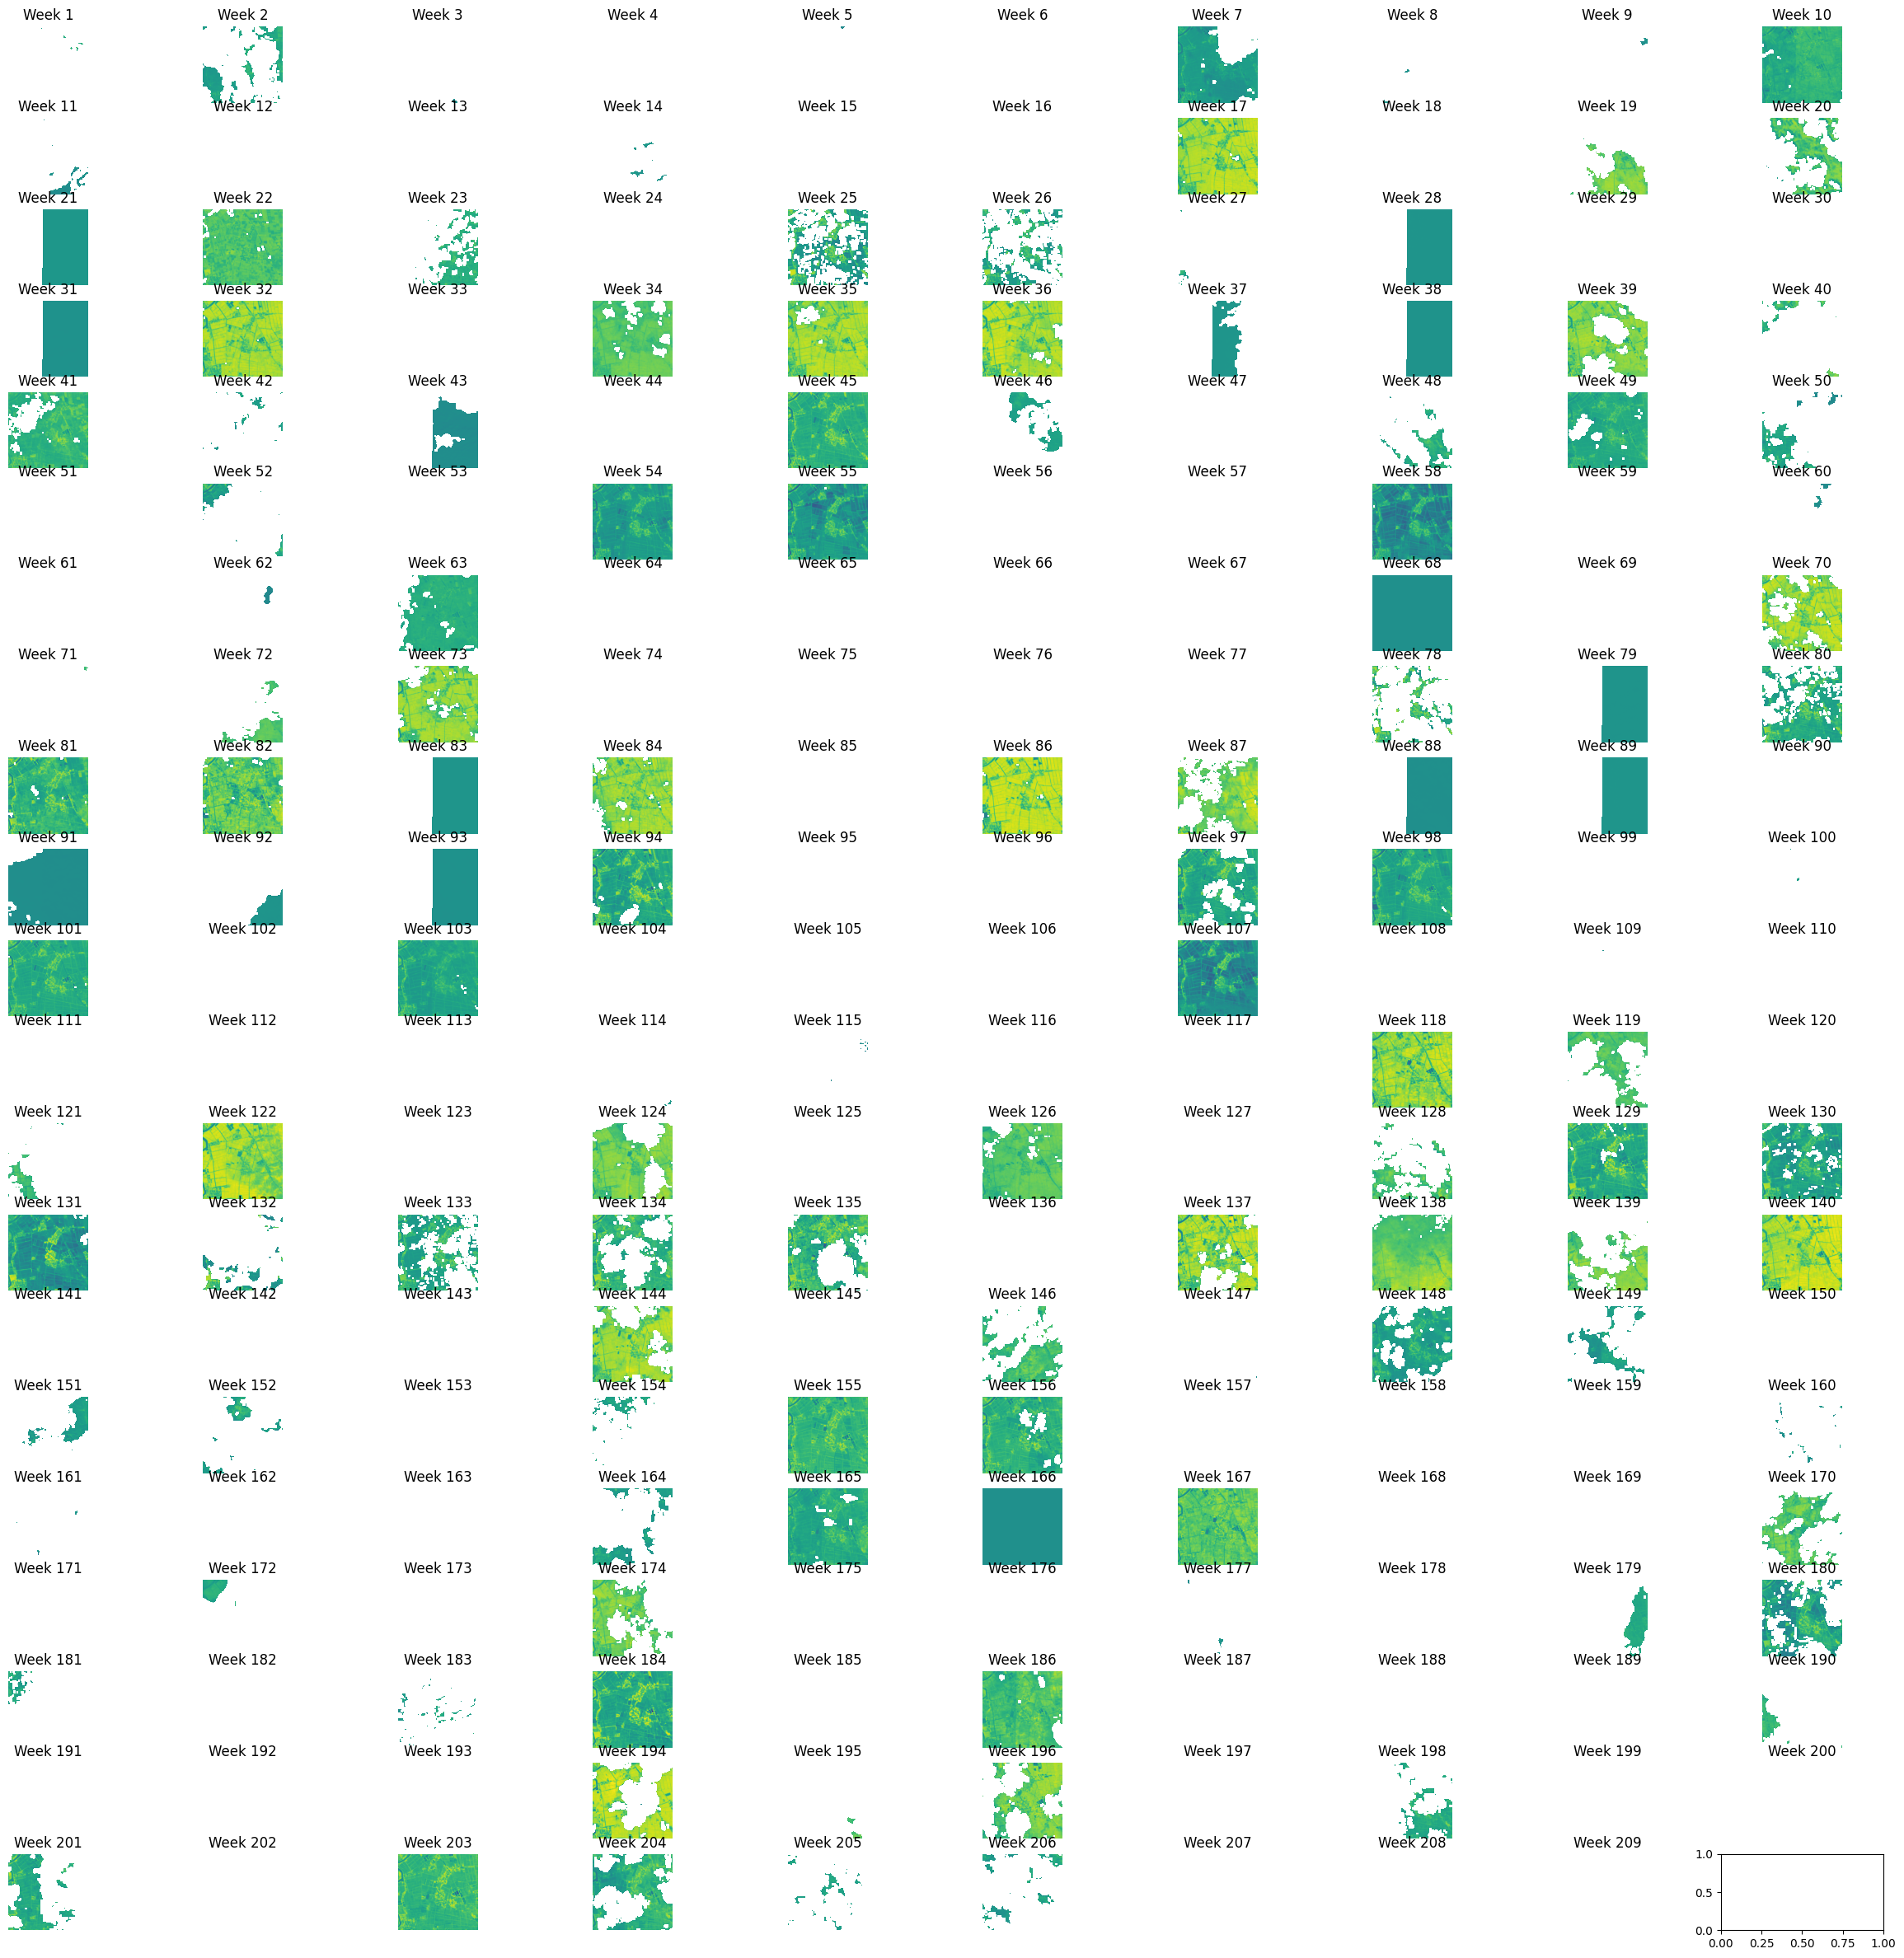

In [ ]:
# Vẽ mảng 2D dưới dạng hình ảnh
import matplotlib.pyplot as plt 

# Tạo bảng 2x5 để hiển thị 10 ảnh
fig, axs = plt.subplots(21, 10, figsize=(30, 30))

# Vẽ từng ảnh trong bảng
for i, ax in enumerate(axs.flat):
    ax.imshow(dakya[i,:,:], cmap='viridis', vmax=1, vmin=-1)  
    ax.set_title(f'Week {i+1}')
    ax.axis('off')  # Ẩn các trục

# Thêm khoảng cách giữa các ô
plt.tight_layout()
plt.show()

In [25]:
def normalize_array(array):
    """
    Chuẩn hóa một mảng về khoảng giá trị [0, 1]
    """
    min_val = np.nanmin(array)
    max_val = np.nanmax(array)
    return (array - min_val) / (max_val - min_val)

X_time_series = []
y_time_series = []
for area_index in range(len(LIST_FOLDER)):
    VV_image = VV_full[area_index]
    VH_image = VH_full[area_index]
    IW_cross_image = IW_cross[area_index]
    IW_ratio_image = IW_ratio[area_index]
    NDVI_image = arr_full[area_index]
    
    # Chuẩn hóa toàn bộ hình ảnh
    VV_image = normalize_array(VV_image)
    VH_image = normalize_array(VH_image)
    IW_cross_image = normalize_array(IW_cross_image)
    IW_ratio_image = normalize_array(IW_ratio_image)
    NDVI_image = normalize_array(NDVI_image)
    
    area_series = []
    y_ = []
    for i in tqdm(range(VH_image.shape[0])):
        image_series = []
        y__ = []
        for x in range(VH_image.shape[1]):
            for y in range(VH_image.shape[2]):
                vv = VV_image[i, x, y]
                vh = VH_image[i, x, y]
                iw_cross = IW_cross_image[i, x, y]
                iw_ratio = IW_ratio_image[i, x, y]
                ndvi = NDVI_image[i, x, y]
                image_series.append(np.array([vv, vh, iw_cross, iw_ratio, ndvi])) 
                y__.append(np.array(ndvi))
        area_series.append(np.array(image_series))
        y_.append(y__)
        
    X_time_series.append(np.array(area_series))
    y_time_series.append(np.array(y_))

100%|██████████| 53/53 [00:04<00:00, 10.96it/s]


In [26]:
area_1 = X_time_series[0].transpose(1, 0, 2)
area_1_y = y_time_series[0].transpose(1,0)

In [27]:
area_1[0][1]

array([0.31372549, 0.        , 0.56089744, 0.        , 0.54356061])

In [28]:
area_1_y.shape

(77028, 53)

In [29]:
area_1 = np.nan_to_num(area_1, 1e-5)
area_1_y = np.nan_to_num(area_1_y, 1e-5)

In [30]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import tensorflow as tf
from tensorflow.keras import (
    Model,
    Sequential,
    losses,
    optimizers,
    metrics,
    layers,
    initializers,
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard,
    LearningRateScheduler,
)
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import itertools
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint

class NDVI_Reconstruction:
    def __init__(self, n_timesteps, n_outputs, n_features):
        self.n_timesteps = n_timesteps
        self.n_outputs = n_outputs
        self.n_features = n_features

    def mse_custom(y_true, y_pred):

        error = tf.where(y_true > 0., y_true - y_pred, 0)

        return K.mean(K.square(error), axis=-1)


    def mae_custom(y_true, y_pred):
        
        error = tf.where(y_true > 0., y_true - y_pred, 0)
        
        return K.mean(K.abs(error), axis=-1)
    
    def add_CNN_block_1D(self, x_inp, filters, kernel_size=3, padding="same", strides=1):
        x = layers.Conv1D(filters,kernel_size,padding=padding, strides=strides,
                      kernel_initializer=initializers.glorot_normal())(x_inp)
        x = layers.Activation('relu')(x)
        return x
    
    def attention_seq(query_value, scale):
        query,value = query_value
        score = tf.matmul(query, value, transpose_b=True) #(batch, timestamp, 1)
        score = scale * score
        score = tf.nn.softmax(score, axis=1)
        score = score * query 
        
        return score
    
    def fusion_model(self, attention=False, cnn_layers=[8,16], pool_size=2, fcl_size=[16,16], lstm_units=32):
        inputs = list([])
        k = list([])
        var = np.array(['vv', 'vh', 'vv_div_vh', 'vh_minus_vv', 'ndvi'])

        for v in var:
            x_inp = layers.Input(shape=(self.n_timesteps, 1), name='{}_input'.format(v))
            inputs.append(x_inp)
            if v == 'ndvi':
                x_inp = layers.Masking(mask_value=-100)(x_inp)
            x = self.add_CNN_block_1D(x_inp, filters=cnn_layers[0])
            x = layers.Dropout(0.2)(x)
            for f in cnn_layers[1:]:
                x = self.add_CNN_block_1D(x, f)
                x = layers.Dropout(0.2)(x)

            x = layers.MaxPooling1D(pool_size=pool_size, strides=None)(x)
            x = layers.Dropout(0.5)(x)
            x = layers.Flatten()(x)
            for f in fcl_size[:-1]:
                x = layers.Dense(f, activation='relu', kernel_initializer=initializers.glorot_normal())(x)
            k.append(x)

        m = layers.Concatenate()(k)
        m = layers.RepeatVector(self.n_outputs)(m)  # Ensure this is applied correctly

        if attention:
            seq, state, _ = layers.LSTM(lstm_units, activation='relu', return_sequences=True, return_state=True)(m)
            att = tf.keras.layers.Lambda(self.attention_seq, arguments={'scale': 0.01})([seq, tf.expand_dims(state, 1)])
            m = layers.LSTM(lstm_units, activation='relu', return_sequences=True)(att)
        else:
            m = layers.Bidirectional(layers.LSTM(lstm_units, activation='relu', return_sequences=False))(m)
            m = layers.RepeatVector(self.n_outputs)(m)
            m = layers.Bidirectional(layers.LSTM(lstm_units, activation='relu', return_sequences=True))(m)

        m = layers.TimeDistributed(layers.Dense(fcl_size[-1], activation='relu', kernel_initializer=initializers.glorot_normal()))(m)
        out = layers.TimeDistributed(layers.Dense(1, activation='sigmoid', kernel_initializer=initializers.glorot_normal()))(m)

        model = Model(inputs=inputs, outputs=out)
        return model

        
    def config_model(self):
        param_grid = {'cnn_layers': [[8,16]],
            'attention': [False],
            'pool_size':[3],
            'fcl_size':[[32,32]],
            'lstm_units':[16]}

        keys, values = zip(*param_grid.items())
        permutations_params = [dict(zip(keys, v)) for v in itertools.product(*values)]


        params = permutations_params[0]
        attention = params['attention']
        cnn_layers = params['cnn_layers']
        pool_size = params['pool_size']
        fcl_size = params['fcl_size']
        lstm_units = params['lstm_units']
    
    
        fusion_model = self.fusion_model(attention=attention, cnn_layers=cnn_layers, pool_size=pool_size, fcl_size=fcl_size, lstm_units=lstm_units)
        
        return fusion_model
    
    # Hàm scheduler để điều chỉnh learning rate
    def scheduler(self, epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * 0.1

    # Sử dụng hàm scheduler với LearningRateScheduler
    change_lr = LearningRateScheduler(scheduler)    
    def training_model(self, X_new_train, y_train, X_new_val, y_val, masks_fused_train, masks_fused_val):
        fusion_model = self.config_model()
        fusion_model.compile(
            optimizer='adam', 
            loss='mean_squared_error',  # MSE Loss
            metrics=['mae']  # MAE Metric
        )        
        batch_size = 1024
        epochs = 100
        ver = 0
        initial_lr = 0.005
        
        model_path = 'models/fusion_model.weights.h5'
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=ver)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=ver, patience=7)
        change_lr = LearningRateScheduler(self.scheduler)
        mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                            verbose=ver, save_best_only=True, save_weights_only=True)

        fusion_model.fit(X_new_train, y_train.reshape(-1, self.n_timesteps, 1),
                        validation_data=(X_new_val, y_val.reshape(-1, self.n_timesteps, 1), masks_fused_val),
                        batch_size=batch_size,
                        sample_weight=masks_fused_train,
                        epochs=epochs,
                        verbose=True,
                        callbacks=[mc, reduce_lr, es, change_lr]
                        )

ModuleNotFoundError: No module named 'seaborn'

In [93]:
n_timesteps, n_features, n_outputs  = area_1.shape[1],area_1.shape[2],area_1.shape[1]
object_rec = NDVI_Reconstruction(n_timesteps=n_timesteps, n_features=n_features, n_outputs=n_outputs)
model = object_rec.config_model()
model.summary()

d:\Streamlit\streamlit-env\Lib\site-packages\keras\src\layers\layer.py:915: UserWarning: Layer 'conv1d_18' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ndvi_input          │ (None, 53, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vv_input            │ (None, 53, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vh_input            │ (None, 53, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vv_div_vh_input     │ (None, 53, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vh_minus_vv_input   │ (None, 53, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, 53, 1)     │          0 │ ndvi_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 53, 8)     │         32 │ vv_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 53, 8)     │         32 │ vh_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 53, 8)     │         32 │ vv_div_vh_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 53, 8)     │         32 │ vh_minus_vv_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 53, 8)     │         32 │ masking_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 53, 8)     │          0 │ conv1d_10[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 53, 8)     │          0 │ conv1d_12[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 53, 8)     │          0 │ conv1d_14[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 53, 8)     │          0 │ conv1d_16[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 53, 8)     │          0 │ conv1d_18[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 53, 8)     │          0 │ activation_10[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 53, 8)     │          0 │ activation_12[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 53, 8)     │          0 │ activation_14[0]

 Total params: 75,857 (296.32 KB)

 Trainable params: 75,857 (296.32 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
area_1.shape

(17604, 53, 5)

In [95]:
from sklearn.model_selection import train_test_split

# Assume that `area_1` is your dataset
total_indices = list(range(area_1.shape[0]))

# Split the indices into 80% for training and 20% for validation
ids_num_train, ids_num_val = train_test_split(total_indices, test_size=0.2, random_state=42)

In [96]:
X_train, X_val = area_1[ids_num_train], area_1[ids_num_val]
y_train, y_val = area_1_y[ids_num_train], area_1_y[ids_num_val]

In [97]:
n_samples = area_1.shape[0]
n_timesteps = area_1.shape[1]

# Create a random mask for each sample

# Optionally, create multiple masks and combine them (fused mask)
mask2 = np.random.choice([0, 1], size=(n_samples, n_timesteps), p=[0.3, 0.7])


# Convert boolean masks to integer masks (0 or 1)
mask_ne = mask2.astype(int)

In [98]:
n_samples = area_1.shape[0]

# Create random sample weights for each sample (weights between 0.5 and 1.5, for example)
sample_weights = np.random.choice([0.25, 0.75], size=(n_samples, n_timesteps))

In [115]:
# Tạo sample_weight với giá trị 0.75 nếu mask[i] = 1, ngược lại là 0.25
sample_weight = np.where(mask_ne == 1, 0.75, 0.25)

print(sample_weight)

[[0.25 0.75 0.25 ... 0.75 0.25 0.75]
 [0.75 0.75 0.75 ... 0.75 0.25 0.75]
 [0.25 0.25 0.75 ... 0.25 0.75 0.75]
 ...
 [0.75 0.25 0.25 ... 0.25 0.75 0.75]
 [0.75 0.25 0.75 ... 0.75 0.25 0.25]
 [0.75 0.75 0.75 ... 0.75 0.25 0.75]]


In [100]:
mask_fused = mask_ne * sample_weights

In [101]:
mask_fused

array([[0.  , 0.75, 0.  , ..., 0.25, 0.  , 0.25],
       [0.25, 0.25, 0.75, ..., 0.25, 0.  , 0.75],
       [0.  , 0.  , 0.75, ..., 0.  , 0.75, 0.75],
       ...,
       [0.75, 0.  , 0.  , ..., 0.  , 0.75, 0.75],
       [0.75, 0.  , 0.25, ..., 0.75, 0.  , 0.  ],
       [0.75, 0.75, 0.25, ..., 0.25, 0.  , 0.25]])

In [102]:
mask_fused_train, mask_fused_val = mask_fused[ids_num_train],mask_fused[ids_num_val]

In [103]:
# Hàm scheduler để điều chỉnh learning rate
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1

# Sử dụng hàm scheduler với LearningRateScheduler
change_lr = LearningRateScheduler(scheduler)

In [104]:
X_new_train = []
X_new_val = []
for i in range(area_1.shape[2]):
    X_new_train.append(X_train[:,:,i].copy())
    X_new_val.append(X_val[:,:,i].copy())

In [105]:
X_new_train[4][0]

array([0.83637915, 0.78700531, 0.73628698, 0.64656321, 0.73053992,
       0.86970637, 0.64102826, 0.64693725, 0.85529714, 0.        ,
       0.78242039, 0.93721098, 0.83532191, 0.72619946, 0.70998119,
       0.74647267, 0.70622437, 0.85993144, 0.80231185, 0.82083668,
       0.        , 0.93127862, 0.88692438, 0.        , 0.78513271,
       0.88219073, 0.72369586, 0.71220216, 0.69597525, 0.91255522,
       0.89172899, 0.83989798, 0.62825029, 0.83389989, 0.97591289,
       0.        , 0.86276102, 0.79906329, 0.8009604 , 0.6629968 ,
       0.73174528, 0.73353858, 0.70977905, 0.73089631, 0.77253498,
       0.90306921, 0.78694435, 0.88586711, 0.88972316, 0.96441883,
       0.94597439, 0.87996697, 0.74831792])

In [106]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Define gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005, clipnorm=1.0)

# Compile the model
model.compile(
    optimizer=optimizer, 
    loss='mean_squared_error',  # MSE Loss
    metrics=['mae']  # MAE Metric
)

# Define callbacks
batch_size = 1024
epochs = 100
ver = 0

model_path = 'models/fusion_model.weights.h5'
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=ver)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=ver, patience=7)
change_lr = LearningRateScheduler(scheduler)
mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                     verbose=ver, save_best_only=True, save_weights_only=True)


# Fit the model
history = model.fit(
    X_new_train, 
    y_train.reshape(-1, n_timesteps, 1),
    validation_data=(X_new_val, y_val.reshape(-1, n_timesteps, 1), mask_fused_val),
    batch_size=batch_size,
    sample_weight=mask_fused_train,
    epochs=epochs,
    verbose=True,
    callbacks=[mc, reduce_lr, es, change_lr]
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 565ms/step - loss: 0.0293 - mae: 0.2206 - val_loss: 0.0214 - val_mae: 0.1967 - learning_rate: 0.0050
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 410ms/step - loss: 0.0204 - mae: 0.1741 - val_loss: 0.0211 - val_mae: 0.1937 - learning_rate: 0.0050
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 389ms/step - loss: 0.0195 - mae: 0.1673 - val_loss: 0.0216 - val_mae: 0.1999 - learning_rate: 0.0050
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 429ms/step - loss: 0.0192 - mae: 0.1662 - val_loss: 0.0207 - val_mae: 0.1911 - learning_rate: 0.0050
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 391ms/step - loss: 0.0190 - mae: 0.1630 - val_loss: 0.0211 - val_mae: 0.1957 - learning_rate: 0.0050
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 393ms/step - loss: 0.0187 - mae: 0.1609 - val_loss: 0.0215 - val_mae: 0.1993 - learning_rate: 0.0050
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - loss: 0.0184 - mae: 0.1580 - val_loss: 0.0212 - val_mae: 0.1974 - learning_rate: 0.002

In [108]:
y_val[0]

array([0.67829162, 0.77010034, 0.85893784, 0.731794  , 0.84940483,
       0.87712331, 0.91886049, 0.66612365, 0.82626851, 0.        ,
       0.76548347, 0.92856453, 0.79899007, 0.8563922 , 0.65889587,
       0.88476085, 0.87642019, 0.9396882 , 0.77311636, 0.94693983,
       0.        , 0.93622228, 0.87542693, 0.        , 0.9184679 ,
       0.92480693, 0.85463378, 0.74880542, 0.86218801, 0.9140171 ,
       0.88971869, 0.85312166, 0.68730568, 0.87625719, 0.94438847,
       0.        , 0.92135507, 0.86674809, 0.87291965, 0.65611346,
       0.78042709, 0.94329472, 0.92617407, 0.92474381, 0.84515422,
       0.93791285, 0.8544377 , 0.87415597, 0.93676859, 0.95366451,
       0.94341416, 0.9311527 , 0.79765276])

106922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


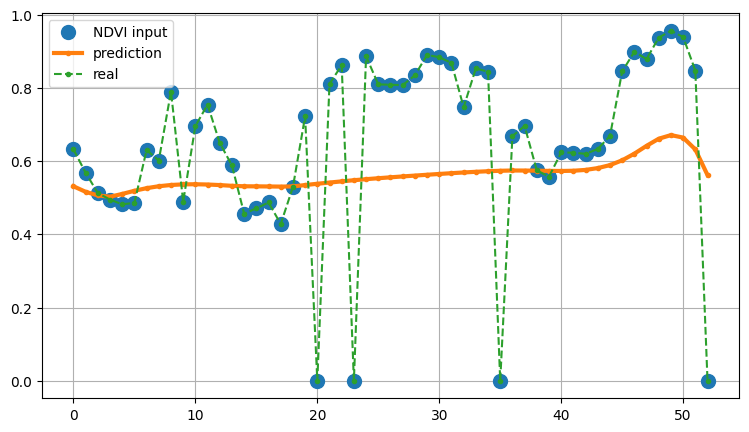

In [114]:
### example case
cc = 106922
print(cc)
yy = y_val[10].copy()
xx = X_val[10]

masked_ndvi = xx[:,-1].copy()
masked_ndvi[masked_ndvi==-100] = np.nan

xx_new = []
for j in range(area_1.shape[2]):
    xx_new.append(xx[:,j].copy().reshape(1,area_1.shape[1]))
pp = model.predict(xx_new).reshape(area_1.shape[1])
plt.figure(figsize=(9,5))
plt.plot(masked_ndvi,marker='.',label='NDVI input',ls='',ms=20)
plt.plot(pp,marker='.',label='prediction',lw=3)
plt.plot(yy,marker='.',ls='--',label='real')
plt.legend()
plt.grid()
plt.show()